Network Analysis of Vaccination Strategies  
Copyright (C) 2020 by The RAND Corporation  
See LICENSE and README.md for information on usage and licensing

# Policy2Vec 

In this notebook I am going to use Doc2Vec (gensim implementation) to map policy documents to numerical vectors, which will then be used for all sorts of NLP tasks. 

## Set-up

In [2]:
## Imports
import os, io, re
import glob
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.linear_model import LinearRegression

from scipy.cluster.hierarchy import dendrogram, fcluster, leaves_list, linkage
from scipy.spatial import distance
#from fastcluster import linkage

import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.style as style 

Some settings to make nicer plots.

In [3]:
style.use('seaborn-paper')

fontsize = 14
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'lines.linewidth': 2
                    },
                   )

initialize some directories

In [4]:
if not os.path.exists("gensim/figures"):
    os.makedirs("gensim/figures")
if not os.path.exists("gensim/models"):
    os.makedirs("gensim/models")

## Corpus Statistics

In [5]:
## paths
docpath = '../web_scraping/documents/parsed_text/'
txtfiles = [f for f in glob.glob(docpath + "**/*.txt", recursive=True)]
print('found %i total documents' % len(txtfiles))

found 37496 total documents


Count the total number of lines in the corpus.

In [7]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [9]:
count = 0
for i in range(len(txtfiles)):
    count += file_len(txtfiles[i])
print('number of lines in corpus = %i' %count)

number of lines in corpus = 63972086


### collect the word counts

In [5]:
word_count = []
for i in range(len(txtfiles)):
    if i % 1000 == 0:
        print('processing document %i' %i)
    doc = open(txtfiles[i], "rb").read().lower().split()
    word_count.append(len(doc))
word_count = np.asarray(word_count)

processing document 0
processing document 1000
processing document 2000
processing document 3000
processing document 4000
processing document 5000
processing document 6000
processing document 7000
processing document 8000
processing document 9000
processing document 10000
processing document 11000
processing document 12000
processing document 13000
processing document 14000
processing document 15000
processing document 16000
processing document 17000
processing document 18000
processing document 19000
processing document 20000
processing document 21000
processing document 22000
processing document 23000
processing document 24000
processing document 25000
processing document 26000
processing document 27000
processing document 28000
processing document 29000
processing document 30000
processing document 31000
processing document 32000
processing document 33000
processing document 34000
processing document 35000
processing document 36000
processing document 37000


Unfortunately, there are some documents which have 0 word count (presumably because the pdftotext operation failed), and there are also some documents with very few words (i.e. 3, 5, etc). These are presumably placeholder documents that say variation of "access to this document is restricted" or "stocked and issued". The 0-word documents should obviously be removed, and the low count documents should also be removed. I'll pick an admittedly arbitrary threshold of 100 words. I'm sure there's a more sophisticated approach for this step. 

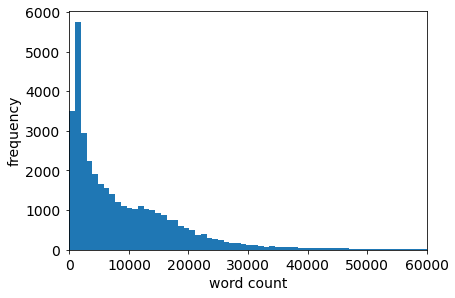

number of documents with 0 words:  45
number of documents with less than 10 words:  53


In [6]:
plt.hist(word_count, bins=500)
plt.xlim(0, 60000)
plt.xlabel('word count')
plt.ylabel('frequency')
plt.show()

print('number of documents with 0 words: ', np.sum(word_count == 0))
print('number of documents with less than 10 words: ', np.sum(word_count < 10))

Repeat the above step, but now only include documents with a word count which exceeds the threshold. This takes awhile.

In [7]:
threshold = 100

txtfiles_new = []
word_count_new = []
vocab = set([])

for i in range(len(txtfiles)):
    if i % 1000 == 0:
        print("processing document %i" %i)
        
    if word_count[i] > threshold:
        word_count_new.append(word_count[i])
        txtfiles_new.append(txtfiles[i])
        
        doc = open(txtfiles[i], "rb").read().lower().split()
        vocab = vocab | set(doc)

word_count_new = np.asarray(word_count_new)
txtfiles_new = np.asarray(txtfiles_new)

processing document 0
processing document 1000
processing document 2000
processing document 3000
processing document 4000
processing document 5000
processing document 6000
processing document 7000
processing document 8000
processing document 9000
processing document 10000
processing document 11000
processing document 12000
processing document 13000
processing document 14000
processing document 15000
processing document 16000
processing document 17000
processing document 18000
processing document 19000
processing document 20000
processing document 21000
processing document 22000
processing document 23000
processing document 24000
processing document 25000
processing document 26000
processing document 27000
processing document 28000
processing document 29000
processing document 30000
processing document 31000
processing document 32000
processing document 33000
processing document 34000
processing document 35000
processing document 36000
processing document 37000


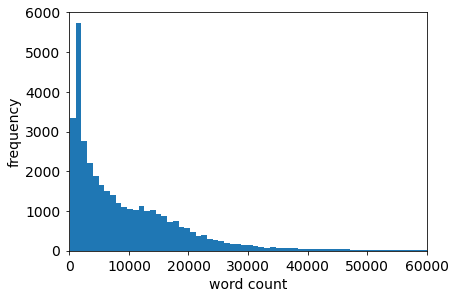

number of documents with 0 words:  0
number of documents with less than 10 words:  0


In [8]:
plt.hist(word_count_new, bins=500)
plt.xlim(0, 60000)
plt.xlabel('word count')
plt.ylabel('frequency')
plt.show()

print('number of documents with 0 words: ', np.sum(word_count_new == 0))
print('number of documents with less than 10 words: ', np.sum(word_count_new < 10))

In [9]:
print('corpus size (documents): ', len(word_count_new))
print('corpus size (words): ', np.sum(word_count_new))
print('vocabulary size: ', len(vocab))
print('\nword count statistics: ')
print('mean: ', np.mean(word_count_new))
print('median: ', np.median(word_count_new))
print('min: ', np.min(word_count_new))
print('max: ', np.max(word_count_new))

corpus size (documents):  36878
corpus size (words):  379920224
vocabulary size:  3569915

word count statistics: 
mean:  10302.083193231738
median:  6377.0
min:  101
max:  479809


### Zipf's Law

The distribution of words in natural language empirically satisfies something known as [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), which has some nice connections to statistical physics. I couldn't help but examine whether or not it held for this corpus - although it should be noted that the raw text files are not "natural" in that there are lots of extraneous symbols and artifacts from the conversion from .pdf to .txt format.

In [10]:
word_freq = {v:0 for v in vocab}
for i in range(len(txtfiles_new)):
    doc = open(txtfiles_new[i], "rb").read().lower().split()
    for x in doc:
        word_freq[x] += 1
        
frequencies = np.sort(np.asarray(list(word_freq.values())))[::-1]
frequencies = frequencies/np.sum(frequencies)

## fit a line
x = np.log(np.asarray([i for i in range(1,len(frequencies)+1)])).reshape(-1, 1)
y =  np.log(frequencies).reshape(-1, 1)
linear_model = LinearRegression().fit(x, y)
#print(linear_model.intercept_)
#print(linear_model.coef_)

## try fitting a line to teh first 10,000 ranks
x_small = np.log(np.asarray([i for i in range(1,len(frequencies)+1)]))[0:10000].reshape(-1, 1)
y_small =  np.log(frequencies)[0:10000].reshape(-1, 1)
model_small = LinearRegression().fit(x_small, y_small)
#print(model_small.intercept_)
#print(model_small.coef_)

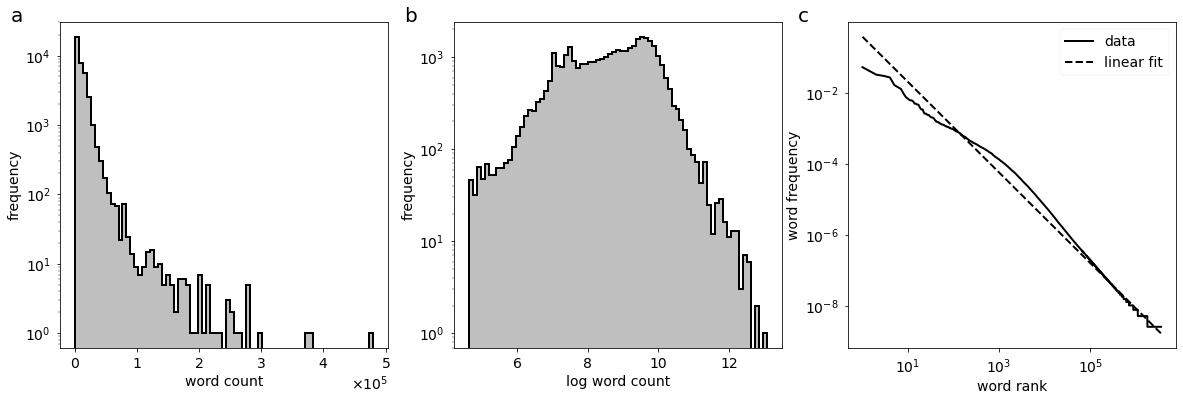

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

## word count
ax1.hist(word_count_new, bins=75, density=False, alpha=1, color='k', histtype='step', linewidth=2)
ax1.hist(word_count_new, bins=75, density=False, alpha=0.25, color='k')
ax1.set_xlabel('word count')
ax1.set_ylabel('frequency')
ax1.set_yscale('log')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.tick_params(axis='both', which='major')
ax1.text(-0.15, 1, 'a', transform=ax1.transAxes, size=20)
ax1.xaxis.major.formatter._useMathText = True
 
## log word count
ax2.hist(np.log(word_count_new), bins=75, density=False, alpha=1, color='k', histtype='step', linewidth=2)
ax2.hist(np.log(word_count_new), bins=75, density=False, alpha=0.25, color='k')
ax2.ticklabel_format(style='plain', axis='both', scilimits=(0,0))
ax2.set_xlabel(r'log word count')
ax2.set_ylabel('frequency')
ax2.set_yscale('log')
ax2.tick_params(axis='both', which='major')
ax2.text(-0.15, 1, 'b', transform=ax2.transAxes, size=20)

## Zipf's law
ax3.plot([i for i in range(1,len(frequencies)+1)], frequencies, color='k', label='data')
ax3.plot(np.exp(x), np.exp(linear_model.coef_[0][0]*x + linear_model.intercept_[0]), color='k', linestyle='dashed', label='linear fit')
ax3.legend()
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('word rank')
ax3.set_ylabel('word frequency')
#ax3.tick_params(axis='sci', which='major')
ax3.text(-0.15, 1, 'c', transform=ax3.transAxes, size=20)

## save and display
#plt.tight_layout()
plt.savefig("gensim/figures/corpus_stats.png", bbox_inches='tight')
plt.show()

Zipf law coefficient

In [12]:
linear_model.coef_[0][0]

-1.271665924796851

## Preprocess the Data

In order to learn document embeddings, we need to preprocess the data. Here I remove stop words, lemmatize, and perform some other steps. This is an important step and I wouldn't be surprised if there are better choices than the ones I made. 

In [13]:
## download nltk utilities
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/gavin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/gavin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gavin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/gavin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
## set stop words
stop_words = set(nltk.corpus.stopwords.words('english'));

In [15]:
## code for lemmatizing entire sentences taken from here: 
## https://simonhessner.de/lemmatize-whole-sentences-with-python-and-nltks-wordnetlemmatizer/

## lemmatizer
lemmatizer = WordNetLemmatizer() 


def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

    
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
    res_words = []
    for word, tag in wn_tagged:
        if tag is None:            
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(res_words)

let's test the effect of the preprocessing on a simple text string:

In [16]:
sentence = "There are some cases where one cannot put a static black hole inside a static soliton. For example, if one puts a small black hole inside a static perfect fluid star it will grow and slowly consume the star. Similarly, one cannot put a static black hole inside a static boson star. The matter content of the soliton determines whether or not one can put a static black hole inside."

nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))

print(nltk_tagged,'\n')
print(map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged),'\n')
print(lemmatize_sentence(sentence))

[('There', 'EX'), ('are', 'VBP'), ('some', 'DT'), ('cases', 'NNS'), ('where', 'WRB'), ('one', 'CD'), ('can', 'MD'), ('not', 'RB'), ('put', 'VB'), ('a', 'DT'), ('static', 'JJ'), ('black', 'JJ'), ('hole', 'NN'), ('inside', 'IN'), ('a', 'DT'), ('static', 'JJ'), ('soliton', 'NN'), ('.', '.'), ('For', 'IN'), ('example', 'NN'), (',', ','), ('if', 'IN'), ('one', 'CD'), ('puts', 'VBZ'), ('a', 'DT'), ('small', 'JJ'), ('black', 'JJ'), ('hole', 'NN'), ('inside', 'IN'), ('a', 'DT'), ('static', 'JJ'), ('perfect', 'NN'), ('fluid', 'NN'), ('star', 'NN'), ('it', 'PRP'), ('will', 'MD'), ('grow', 'VB'), ('and', 'CC'), ('slowly', 'RB'), ('consume', 'VB'), ('the', 'DT'), ('star', 'NN'), ('.', '.'), ('Similarly', 'RB'), (',', ','), ('one', 'CD'), ('can', 'MD'), ('not', 'RB'), ('put', 'VB'), ('a', 'DT'), ('static', 'JJ'), ('black', 'JJ'), ('hole', 'NN'), ('inside', 'IN'), ('a', 'DT'), ('static', 'JJ'), ('boson', 'NN'), ('star', 'NN'), ('.', '.'), ('The', 'DT'), ('matter', 'NN'), ('content', 'NN'), ('of', 'I

In [17]:
def preprocessing(doc_path):  
    """preprocessing step for text inputs"""
    
    words = io.open(doc_path, 'r', encoding='utf-8', errors='ignore').read()
    
    ## covert to all lower-case
    words = words.lower()
    
    ## remove numbers
    words = re.sub(r'[0-9]+', '', words)

    ## lemmatize
    words = lemmatize_sentence(words)
    
    ## tokenize
    words = words.split()
    
    ## remove stop-words
    words = [w for w in words if w not in stop_words]

    return words


def cosine_similarity(v1, v2):
    """
    cosine simliarity, i.e. \cos(\theta) = \left( \frac{v1*v2}{||v1|| ||v2|} \right)
    """
    norm1 = np.sqrt(np.dot(v1, v1))
    norm2 = np.sqrt(np.dot(v2, v2))
    
    return np.dot(v1, v2)/norm1/norm2


def angular_distance(v1, v2):
    """
    angular distance, i.e. dist(v1, v2) = \cos^{-1}(\cosine simliarity(v1, v2))/\pi
    """
    cos_sim = cosine_similarity(v1, v2)
    return np.arccos(cos_sim)/np.pi

## Preprocess the data

This step takes more than an hour, so it might be nice to save it. Be warned, however, that the filesize is more than 1 GB.

In [18]:
## These are flags I use to control whether I load the tagged data from file or whether I tag it here.
data_load = False

In [ ]:
if data_load:
    word_list = list(np.load('gensim/word_list.npy'))
    tag_list = list(np.load('gensim/tag_list.npy'))

else:
    word_list = []
    tag_list = []

    for i in range(len(txtfiles_new)):
        
        if i % 1000 == 0:
            print('processing document %i' %i)
        
        ## i-th document
        doc_path = txtfiles_new[i]

        ## unique doc id
        tags = [str(i)]

        ## the words of the doc
        words = preprocessing(doc_path)

        ## add non-unique tags describing the doc type
        if 'Lemay_Center' in doc_path:
            tags.extend(['AF', 'AF:Lemay Center'])
        if 'bases' in doc_path:
            tags.extend(['AF', 'AF:bases'])
        if 'departmental' in doc_path:
            tags.extend(['AF', 'AF:departmental'])
        if 'dru' in doc_path:
            tags.extend(['AF', 'AF:dru'])
        if 'foa' in doc_path:
            tags.extend(['AF', 'AF:foa'])   
        if 'majcom' in doc_path:
            tags.extend(['AF', 'AF:majcom'])
        if 'natlguard' in doc_path:
            tags.extend(['AF', 'AF:natlguard'])
        if 'numberedAFB' in doc_path:
            tags.extend(['AF', 'AF:numberedAFB'])
        if 'units' in doc_path:
            tags.extend(['AF', 'AF:units'])
        if 'admin_instructions' in doc_path:
            tags.extend(['DoD', 'DoD:admin_instructions'])        
        if 'directives' in doc_path:
            tags.extend(['DoD', 'DoD:directives'])         
        if 'dtms' in doc_path:
            tags.extend(['DoD', 'DoD:dtms'])        
        if 'instructions' in doc_path:
            tags.extend(['DoD', 'DoD:instructions'])        
        if 'manuals' in doc_path:
            tags.extend(['DoD', 'DoD:manuals'])        
        if 'joint_doctrine_pubs' in doc_path:
            tags.extend(['JCS', 'JCS:joint_doctrine_pubs'])            

        word_list.append(words)
        tag_list.append(tags)
        
    ## save the final result
    np.save('gensim/word_list', np.asarray(word_list))
    np.save('gensim/tag_list', np.asarray(tag_list))

processing document 0
processing document 1000
processing document 2000
processing document 3000
processing document 4000
processing document 5000
processing document 6000
processing document 7000
processing document 8000
processing document 9000
processing document 10000
processing document 11000
processing document 12000
processing document 13000
processing document 14000
processing document 15000
processing document 16000
processing document 17000
processing document 18000
processing document 19000
processing document 20000
processing document 21000
processing document 22000
processing document 23000
processing document 24000
processing document 25000
processing document 26000
processing document 27000
processing document 28000
processing document 29000
processing document 30000
processing document 31000
processing document 32000
processing document 33000
processing document 34000
processing document 35000
processing document 36000


In [1]:
## combine everything into a data list
data = []
for i in range(len(word_list)):
    data.append(TaggedDocument(words=word_list[i], tags=tag_list[i]))

## check that all these lengths are the same
print(len(txtfiles_new))
print(len(data))
print(len(word_list))

NameError: name 'word_list' is not defined

## Build the Model

In [ ]:
## Similar flag as above
model_load = False

In [ ]:
vecsize = 100

if model_load:
    #load the model
    model = Doc2Vec.load('gensim/models/d2v_vecsize_' + str(vecsize) + '.model')
    
else:
    ## define the model
    model = Doc2Vec(vector_size=vecsize, alpha=0.025, min_alpha=0.00025, min_count=10, dm =1)
    model.build_vocab(data)

    ## train the model
    max_epochs = 100
    for epoch in range(max_epochs):
        print('iteration {0}'.format(epoch))
        model.train(data, total_examples=model.corpus_count, epochs=model.epochs)
        # decrease the learning rate
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        #model.min_alpha = model.alpha

    
    model.save('gensim/models/d2v_vecsize_' + str(vecsize) + '.model')
    print("Model Saved")

In [ ]:
## generate the labels
labels = [ data[i].tags[2] for i in range(len(data))]
dic = {list(set(labels))[i]:i for i in range(len(list(set(labels))))}

## generate a numpy array of all the vectors
vec = np.zeros((len(data), vecsize))
for i in range(len(data)):
    vec[i] = model.docvecs[str(i)]
    
## distance matrix using angular distance    
dij = np.zeros((len(data), len(data)))
for i in range(0, len(data)-1):
    for j in range(i+1, len(data)):
        dij[i,j] = angular_distance(model.docvecs[str(i)], model.docvecs[str(j)])
        dij[j,i] = dij[i,j]

## Closest document to a given document

In [ ]:
i = 0
while True:
    if 'afttp3-2.55.txt' in txtfiles_new[i]:
        break
    i += 1
    
print(txtfiles_new[i])
print(txtfiles_new[np.argsort(dij[i])[1]])
print(txtfiles_new[np.argsort(dij[i])[2]])
print(txtfiles_new[np.argsort(dij[i])[3]])

In [ ]:
i = 0
while True:
    if '465005p.txt' in txtfiles_new[i]:
        break
    i += 1
    
print(txtfiles_new[i])
print(txtfiles_new[np.argsort(dij[i])[1]])
print(txtfiles_new[np.argsort(dij[i])[2]])

In [ ]:
i = 0
while True:
    if 'acci36-2801.txt' in txtfiles_new[i]:
        break
    i += 1
    
print(txtfiles_new[i])
print(txtfiles_new[np.argsort(dij[i])[1]])
print(txtfiles_new[np.argsort(dij[i])[2]])

In [ ]:
i = 0
while True:
    if '415118h.txt' in txtfiles_new[i]:
        break
    i += 1
    
print(txtfiles_new[i])
print(txtfiles_new[np.argsort(dij[i])[1]])
print(txtfiles_new[np.argsort(dij[i])[2]])

## Hierarchical Clustering

I used this example to figure out how the linkage matrix encodes the clustering

In [ ]:
matplotlib.rcParams['lines.linewidth'] = 2

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

permute = np.random.permutation(len(data))
nsmall = 50

dij_small = [[dij[i,j] for i in permute[0:nsmall]] for j in permute[0:nsmall]]
dij_small2 = np.asarray(dij_small)

linkage_matrix = linkage(distance.squareform(dij_small2), "single")
#ax.axis('off')
ddn = dendrogram(linkage_matrix, no_labels=True, color_threshold=0, link_color_func=lambda k: 'k')#, ax=ax)
leaves = np.asarray(ddn['leaves'])

ax.plot(np.ones(10), 0.3*np.ones(10))
          
plt.savefig('gensim/figures/dendrogram_small.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fc = fcluster(Z=linkage_matrix, t=0.425, criterion='distance')
# Returns: an array of length n. T[i] is the flat cluster number to which original observation i belongs.
print('number of clusters at this threshold: ', len(set(fc)))
print(fc)

In [ ]:
dij_small2_sorted = np.ones((nsmall, nsmall))
for i in range(nsmall):
    for j in range(nsmall):
        dij_small2_sorted[i,j] = dij_small2[leaves[i], leaves[j]]

In [ ]:
fig = plt.figure(figsize=(5,7))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan= 1, colspan=1)
cm = matplotlib.cm.inferno
#cm = "coolwarm"

dd = dendrogram(linkage_matrix, color_threshold=0, above_threshold_color='black', \
                    no_plot=False, no_labels=True, count_sort="descending")

ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan= 2, colspan=1);
plt.pcolor(np.rot90(dij_small2_sorted, k=1, axes=(0, 1)), cmap=cm)
ax2.set_xticks([])
ax2.set_yticks([])

### full dendrogram

In [ ]:
matplotlib.rcParams['lines.linewidth'] = 0.5 #2.0 old value

In [ ]:
#dij_permute = [[dij[i,j] for i in permute] for j in permute]

fig = plt.figure(figsize=(20,10))
fs = 20
plt.axis('off')
dists = distance.squareform(dij)
linkage_matrix = linkage(dists, "single")
dd = dendrogram(linkage_matrix, no_labels=True, color_threshold=0, link_color_func=lambda k: 'k')#, labels=["0", "1", "2"])
#plt.title("Dendrogram", fontsize=fs)
plt.show()

In [ ]:
dij.shape

In [ ]:
leaves = np.asarray(dd['leaves'])

In [ ]:
dij_sorted = np.ones((len(dij), len(dij)))
for i in range(len(dij)):
    for j in range(len(dij)):
        dij_sorted[i,j] = dij[leaves[i], leaves[j]]

In [ ]:
import scipy
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(16,16))
ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
Y = sch.linkage(dists, method='single')
Z1 = sch.dendrogram(Y, orientation='left', color_threshold=0, link_color_func=lambda k: 'k')
ax1.set_xticks([])
ax1.set_yticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Y = sch.linkage(dists, method='single')
Z2 = sch.dendrogram(Y, color_threshold=0, link_color_func=lambda k: 'k')
ax2.set_xticks([])
ax2.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
#D = D[idx1,:]
#D = D[:,idx2]
im = axmatrix.matshow(dij_sorted, aspect='auto', origin='lower', cmap=cm)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)
fig.show()
fig.savefig('gensim/figures/dendrogram.pdf')

In [ ]:
matplotlib.rcParams['lines.linewidth'] = 2.0

In [ ]:
linkage_matrix = linkage(dists, "single")
fc = fcluster(Z=linkage_matrix, t=0.309, criterion='distance')
# Returns: an array of length n. T[i] is the flat cluster number to which original observation i belongs.

cluster_nums = sorted(list(set(fc)))
clusters = {i:[] for i in cluster_nums}
for i in range(len(fc)):
    clusters[fc[i]].append(i)
    
print(r'$\alpha_c = %.2f$' % ((len(set(fc))-1)/(len(fc)-1)))

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 9))
tlist = [0.0, 0.1, 0.15, 0.2, 0.3, 0.35]
axlist = [ax1, ax2, ax3, ax4, ax5, ax6]
abclist = ['a', 'b', 'c', 'd', 'e', 'f']

for k in range(len(tlist)):
    fc = fcluster(Z=linkage_matrix, t=tlist[k], criterion='distance')
    # Returns: an array of length n. T[i] is the flat cluster number to which original observation i belongs.

    cluster_nums = sorted(list(set(fc)))
    clusters = {i:[] for i in cluster_nums}
    for i in range(len(fc)):
        clusters[fc[i]].append(i)

    #ax2.ticklabel_format(style='plain', axis='both', scilimits=(0,0))
    #ax2.set_xlabel(r'log word count')
    #ax2.set_ylabel('frequency')
    #ax2.tick_params(axis='both', which='major')

    ax = axlist[k]
    cluster_sizes = np.sort([ len(clusters[i+1]) for i in range(max(fc)) ])
    ax.hist(cluster_sizes, bins=15, density=False, alpha=1, color='k', histtype='step', linewidth=2)
    ax.hist(cluster_sizes, bins=15, density=False, alpha=0.25, color='k')
    ax.set_xlabel('cluster size')
    ax.set_yscale('log')
    #ax1.set_xlim(1, 80)
    ax.text(-0.15, 1.02, abclist[k], transform=ax.transAxes, size=20)
    ax.text(0.6, 0.9, r'$\alpha_c = %.2f$' % ((len(set(fc))-1)/(len(fc)-1)), size=20, transform=ax.transAxes)

plt.savefig("gensim/figures/cluster_size.png", bbox_inches='tight')
plt.show()